In [1]:
import pandas as pd

In [2]:
#Read the Zillow house price development data into a DataFrame called df
df = pd.read_csv('https://github.com/JaFaSch/house-market-prediction/raw/main/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [3]:
#Read S&P 500 historical data into a DataFrame called df_SP
df_SP = pd.read_csv('https://github.com/JaFaSch/house-market-prediction/raw/main/S%26P%20500%20Historical%20Data.csv')

In [4]:
#Remove unnecessary columns from the Zillow data
columns_to_drop = ['RegionID', 'SizeRank', 'RegionType', 'StateName']
df = df.drop(columns=columns_to_drop)

In [5]:
#Remove unnecessary columns from the S&P 500 data
df_SP.drop(columns=['Open', 'High', 'Low', 'Vol.','Change %'], inplace=True)

In [6]:
#Reverse the order of rows in df_SP (making the oldest date first) and reset the index
df_SP = df_SP.iloc[::-1].reset_index(drop=True)

In [7]:
# Extract the first column of df
first_column = df.iloc[:, 0]
# Extract the rest of the columns from df for interpolation
remaining_columns = df.iloc[:, 1:]
# Convert object-type columns to more specific types like numeric if possible
remaining_columns = remaining_columns.infer_objects()
# Fill missing values in remaining_columns using linear interpolation
remaining_columns_interpolated = remaining_columns.interpolate(method='linear', limit_direction='both')
# Combine the first column with the interpolated data
df = pd.concat([first_column, remaining_columns_interpolated], axis=1)

In [8]:
# Ensure no NaN values are present in the DataFrame
nan_counts_per_column = df.isnull().sum()
print("NaN values per column:")
print(nan_counts_per_column)
total_nan_count = nan_counts_per_column.sum()
print("\nTotal number of NaN values in the DataFrame:")
print(total_nan_count)

NaN values per column:
RegionName    0
2000-01-31    0
2000-02-29    0
2000-03-31    0
2000-04-30    0
             ..
2024-05-31    0
2024-06-30    0
2024-07-31    0
2024-08-31    0
2024-09-30    0
Length: 298, dtype: int64

Total number of NaN values in the DataFrame:
0


In [9]:
# Set the 'RegionName' column as the index for the Zillow DataFrame
df.set_index('RegionName', inplace=True)
# Transpose df so that the regions are now the columns and the dates are the rows
df_final= df.T
# Drop the last row in the transposed DataFrame
df_final = df_final.drop(df_final.index[-1])
# Convert the index of df_final to datetime format
df_final.index = pd.to_datetime(df_final.index)
# Adjust the frequency of the DataFrame to monthly
df_final = df_final.asfreq('M')

In [10]:
df_SP['Price']

0      1,366.40
1      1,498.60
2      1,452.40
3      1,420.60
4      1,454.60
         ...   
291    5,277.51
292    5,460.48
293    5,522.30
294    5,648.40
295    5,762.48
Name: Price, Length: 296, dtype: object

In [11]:
# Clean the 'Price' column by removing commas, converting to float
df_SP['Price'] = df_SP['Price'].str.replace(',', '').astype(float)

In [12]:
df_final.index = pd.to_datetime(df_final.index)
# Convert the 'Date' column in df_SP to datetime format
df_SP['Date'] = pd.to_datetime(df_SP['Date']) 
# Set 'Date' as the index for df_SP
df_SP.set_index('Date', inplace=True) 

# Compare the number of rows between df_SP and df_final to ensure alignment
if len(df_SP) != len(df_final):
    print("Warning: df_SP and df_final do not have the same number of rows.")
else:
    print("df_SP and df_final have the same number of rows.")
    # Add the 'Price' column from df_SP into df_final as the first column
    df_final.insert(0, 'Price', df_SP['Price'].values)


df_SP and df_final have the same number of rows.


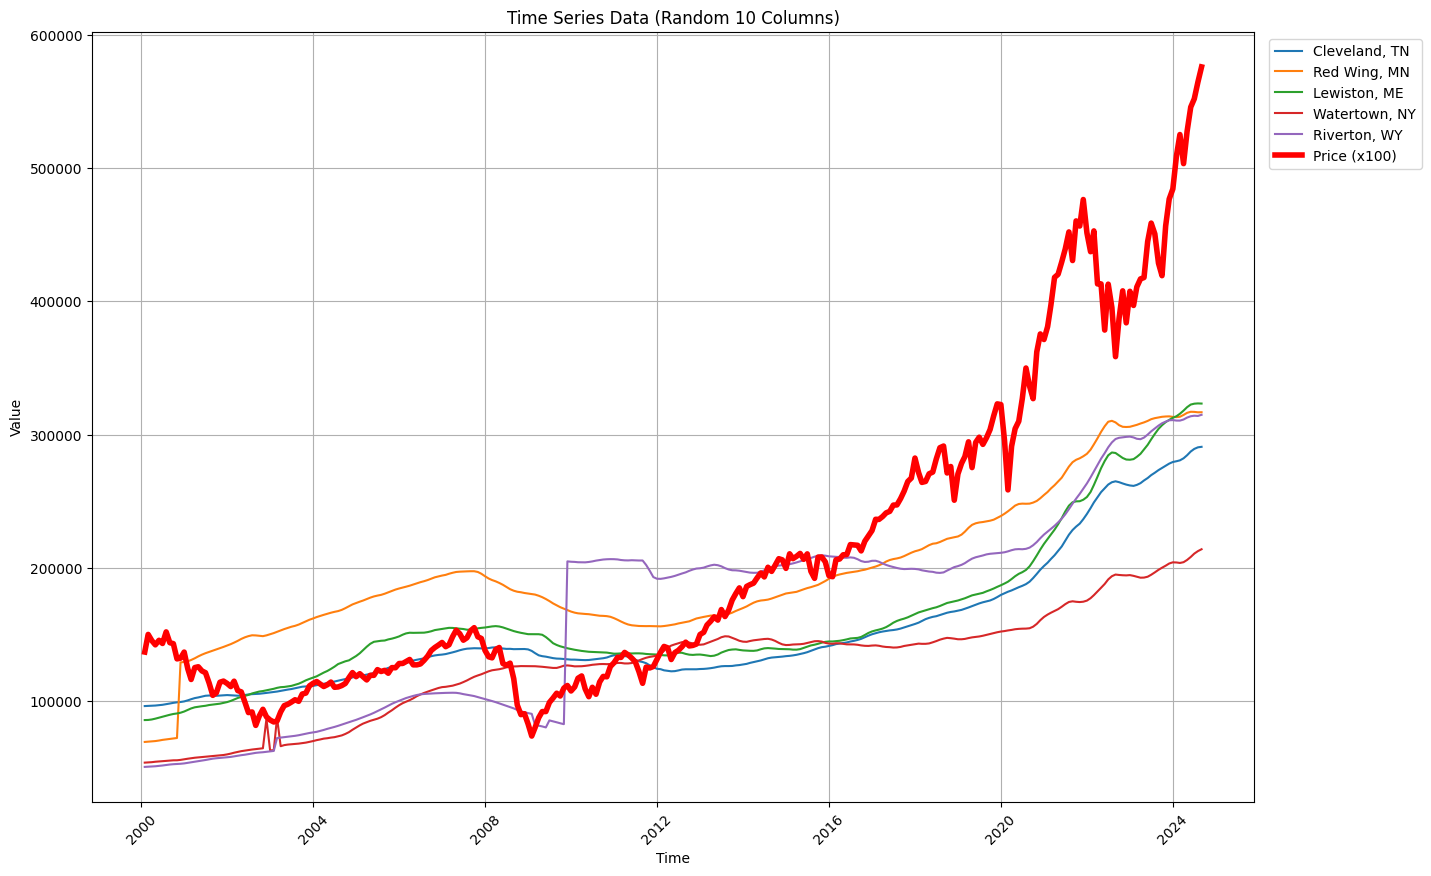

In [13]:
import matplotlib.pyplot as plt
import random
# Select 5 random columns (ensuring 'Price' is included) and plots their time series against the index
random_columns = random.sample(list(df_final.columns), 5)
if 'Price' not in random_columns:
    random_columns.append('Price')
plt.figure(figsize=(15, 10))
for column in random_columns:
    if column == 'Price':
        plt.plot(df_final.index, df_final['Price']*100, label=f'{column} (x100)', color = 'red', linewidth=4)
    else:
        plt.plot(df_final.index, df_final[column], label=column)


plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data (Random 10 Columns)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.show()

In [14]:
import ipywidgets as widgets
from IPython.display import display
# Provide a user-friendly dropdown to select a city column from the dataset for analysis
column_names = sorted(df_final.columns[1:].tolist())
import json
with open('column_names.json', 'w') as f:
    json.dump(column_names, f)
dropdown = widgets.Dropdown(
    options=column_names,
    description='Columns:',
    disabled=False,
)

display(dropdown)

Dropdown(description='Columns:', options=('Aberdeen, SD', 'Aberdeen, WA', 'Abilene, TX', 'Ada, OK', 'Adrian, M…

In [15]:
city = dropdown.value

In [16]:
# Check if the selected city is valid; if not, defaults to 'United States'
if city in df_final.columns:
    print(f"'{city}' is a column name.")
    state_data = df_final[city]
else:
    print(f"'{city}' is not a column name.")
    city = 'United States'
    state_data = df_final['city']

'Aberdeen, SD' is a column name.


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

In [18]:
# Define a function to predict house prices using lagged features and ARIMA
def predict_houseprice(lag_SP, lag_house, city, forecast_periods=6):
    # Create lagged versions of house price and S&P 500 index columns based on the provided lag values
    df_final['HousePrice_Lag1'] = df_final[city].shift(lag_house)
    df_final['SP500_Lag1'] = df_final['Price'].shift(lag_SP)
    df_final.dropna(inplace=True)
    # Move the lagged columns (HousePrice_Lag1 and SP500_Lag1) to specific positions for better organization
    df_final.insert(2, 'HousePrice_Lag1', df_final.pop('HousePrice_Lag1'))
    df_final.insert(3, 'SP500_Lag1', df_final.pop('SP500_Lag1'))
    # Normalize lagged features using StandardScaler to ensure all inputs have a mean of 0 and a standard deviation of 1
    scaler = StandardScaler()
    df_final[['HousePrice_Lag1', 'SP500_Lag1']] = scaler.fit_transform(df_final[['HousePrice_Lag1', 'SP500_Lag1']])
    # Split the data into training (80%) and testing (20%) sets for features (SP500_Lag1) and target (city).
    train_size = int(len(df_final) * 0.8)
    X_train, X_test = df_final[['SP500_Lag1']][:train_size], df_final[['SP500_Lag1']][train_size:]
    y_train, y_test = df_final[city][:train_size], df_final[city][train_size:]
    # Training ARIMA Models
    best_mae = np.inf
    best_order = None
    best_model = None
    for p in range(0, 2):  # Try p values from 0 to 2
        for d in range(0, 2):  # d = 0 (no differencing) and d = 1 (first differencing) and d = 2 (second differencing)
            for q in range(0, 2):  # Try q values from 0 to 2
                try:
                    model = ARIMA(y_train, order=(p, d, q), exog=X_train)
                    model_fit = model.fit()
                    y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
                    
                    mae = mean_absolute_error(y_test, y_pred)
                    if mae < best_mae:
                        best_mae = mae
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception as e:
                    continue
    # Use the last value of X_test to predict future values for the specified forecast_periods
    future_exog = np.tile(X_test.iloc[-1].values, (forecast_periods, 1))  # Use the last SP500_Lag1 value for future
    future_pred = best_model.forecast(steps=forecast_periods, exog=future_exog)

    # Combine historical test predictions and future predictions
    y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
    y_pred_combined = np.concatenate([y_pred, future_pred])

    # MAE and MSE for test set
    mae = mean_absolute_error(y_test, y_pred[:len(y_test)])
    mse = mean_squared_error(y_test, y_pred[:len(y_test)])
    return y_test, y_pred_combined, train_size, df_final.index[train_size:], future_pred, best_model, X_test

In [19]:
import warnings
best_mae = float('inf')
best_mse = float('inf')
best_lag_SP = None
best_lag_house = None
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found")
# Test various combinations of lag values to determine the best-performing configuration.
for lag_SP in range(6, 12):
    for lag_house in range(1, 4):
        y_test, y_pred, train_size, pred_index, future_pred, best_model, X_test = predict_houseprice(lag_SP, lag_house, city)
        y_pred_combined = np.concatenate([y_pred, future_pred])
        mae = mean_absolute_error(y_test, y_pred[:len(y_test)])
        mse = mean_squared_error(y_test, y_pred[:len(y_test)])
        print(f"lag_SP: {lag_SP}, lag_house: {lag_house}, MAE: {mae}, MSE: {mse}")
        
        # Update the best MAE and the corresponding lag values if the current MAE is better
        if mae < best_mae:
            best_mae = mae
            best_lag_SP = lag_SP
            best_lag_house = lag_house




lag_SP: 6, lag_house: 1, MAE: 13871.770593091704, MSE: 314522863.98388034
lag_SP: 6, lag_house: 2, MAE: 11433.452720173851, MSE: 225865000.14720395


lag_SP: 6, lag_house: 3, MAE: 11480.51867903076, MSE: 223960793.14997154
lag_SP: 7, lag_house: 1, MAE: 10321.360329325786, MSE: 173122416.754367
lag_SP: 7, lag_house: 2, MAE: 9939.347089415298, MSE: 153675692.0605315
lag_SP: 7, lag_house: 3, MAE: 9422.249278660976, MSE: 126115764.4542843
lag_SP: 8, lag_house: 1, MAE: 8604.340274396516, MSE: 101202505.8143712


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


lag_SP: 8, lag_house: 2, MAE: 8225.235655714549, MSE: 98120369.6094563
lag_SP: 8, lag_house: 3, MAE: 7855.988383824944, MSE: 86736505.54007265
lag_SP: 9, lag_house: 1, MAE: 9358.235237929246, MSE: 136802565.158566


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


lag_SP: 9, lag_house: 2, MAE: 10472.958725410332, MSE: 169674594.91266274
lag_SP: 9, lag_house: 3, MAE: 8693.412626149962, MSE: 114810228.36055839


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


lag_SP: 10, lag_house: 1, MAE: 8727.142520648757, MSE: 121834993.05530226


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


lag_SP: 10, lag_house: 2, MAE: 10416.46477117849, MSE: 126224556.23377456


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


lag_SP: 10, lag_house: 3, MAE: 8474.832360465267, MSE: 83558887.46928933


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


lag_SP: 11, lag_house: 1, MAE: 8282.15096214639, MSE: 74734120.21970434


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


lag_SP: 11, lag_house: 2, MAE: 4982.964185165187, MSE: 28490181.505909994
lag_SP: 11, lag_house: 3, MAE: 1842.4003482533935, MSE: 5392200.883130177


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Print the best MAE and the corresponding lag values
print(f"Best MAE: {best_mae} with lag_SP: {best_lag_SP} and lag_house: {best_lag_house}")
print(f"Best MSE: {best_mse} with lag_SP: {best_lag_SP} and lag_house: {best_lag_house}")

Best MAE: 1842.4003482533935 with lag_SP: 11 and lag_house: 3
Best MSE: inf with lag_SP: 11 and lag_house: 3


In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [25]:
# The regressors dictionary defines three regression models 
# (RandomForest, GradientBoosting, LinearRegression) with their respective hyperparameters for tuning
regressors = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
        },
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 10],
        },
    },
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {},  
    },
}


In [26]:
# Prepare data for regressors
X = df_final[['SP500_Lag1']].iloc[:train_size]  # Features (up to train size)
y = df_final[city].iloc[:train_size]  # Target (up to train size)

In [27]:
# Initialize an empty dictionary to store the results of GridSearchCV for each regressor, 
# including the best model and its corresponding Mean Absolute Error (MAE)
grid_search_results = {}

In [28]:

# Perform GridSearchCV for each regressor, optimize MAE, and store the best model and score.
for regressor_name, regressor in regressors.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', regressor['model']),
    ])
    grid_search = GridSearchCV(
        pipeline,
        param_grid=regressor['params'],
        scoring='neg_mean_absolute_error',
        cv=3,  # 3-fold cross-validation
        n_jobs=-1,
        verbose=2,
    )
    print(f"Running GridSearchCV for {regressor_name}...")
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    best_score = -grid_search.best_score_  # Convert back to positive MAE
    grid_search_results[regressor_name] = {
        'model': best_model,
        'MAE': best_score,
    }
    

Running GridSearchCV for RandomForest...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......model__max_depth=None, model__n_estimators=50; total time=   0.0s
[CV] END ......model__max_depth=None, model__n_estimators=50; total time=   0.1s
[CV] END ......model__max_depth=None, model__n_estimators=50; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=100; total time=   0.2s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=   0.1s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=   0.1s
[CV] END ........model__max_depth=10, model__n_estimators=50; total time=   0.1s
[CV] END .....model__max_depth=None, model__n_estimators=200; total time=   0.3s
[CV] END .....model__max_depth=None, model__n_estimators=200; total time=   0.3s
[CV] END

In [29]:
print("\nGrid Search Results:")
for model_name, result in grid_search_results.items():
    print(f"{model_name}: Best MAE = {result['MAE']:.4f}")


Grid Search Results:
RandomForest: Best MAE = 10434.7735
GradientBoosting: Best MAE = 10111.6160
LinearRegression: Best MAE = 11928.1970


In [30]:
# Compare best regressor with the best ARIMA model
best_regressor_name = min(grid_search_results, key=lambda name: grid_search_results[name]['MAE'])
best_regressor_mae = grid_search_results[best_regressor_name]['MAE']

In [38]:
# Print the best method and its corresponding MAE
print("\nComparison:")
print(f"Best ARIMA MAE: {best_mae}")
print(f"Best Regressor ({best_regressor_name}) MAE: {best_regressor_mae}")

if best_regressor_mae < best_mae:
    print(f"The best regressor ({best_regressor_name}) outperforms the ARIMA model.")
else:
    print("The ARIMA model outperforms all tested regressors.")



Comparison:
Best ARIMA MAE: 1842.4003482533935
Best Regressor (GradientBoosting) MAE: 10111.61597472311
The ARIMA model outperforms all tested regressors.


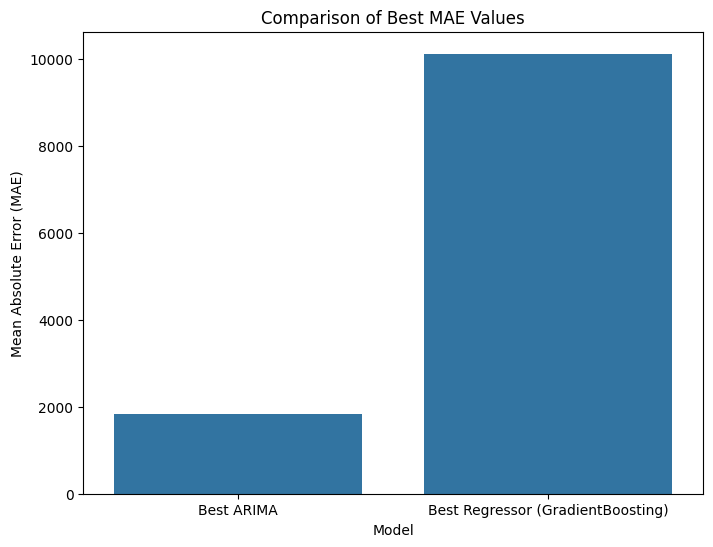

In [32]:
# Plot comparison of best MAE values
import seaborn as sns
data = {
    'Model': ['Best ARIMA', f'Best Regressor ({best_regressor_name})'],
    'MAE': [best_mae, best_regressor_mae]
}

df_mae = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='MAE', data=df_mae)
plt.title('Comparison of Best MAE Values')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Model')
plt.show()

In [20]:
# Initialize a DataFrame with actual and predicted house prices, setting predictions as NaN initially
predicted_df = pd.DataFrame({
    'Actual': df_final[city],
    'Predicted': np.nan  # Start with NaN for the predictions
}, index=df_final.index)

# Fill the 'Predicted' column with predictions starting from the training size
predicted_df.loc[pred_index, 'Predicted'] = y_pred[:len(pred_index)]  # Use pred_index here and limit y_pred

# Include future predictions as well
if future_pred is not None:
    # Calculate the start index for future predictions
    future_start_index = pred_index[-1] + pd.DateOffset(months=1)  # Next month after last prediction
    predicted_df.loc[future_start_index:future_start_index + pd.DateOffset(months=len(future_pred)-1), 'Predicted'] = future_pred


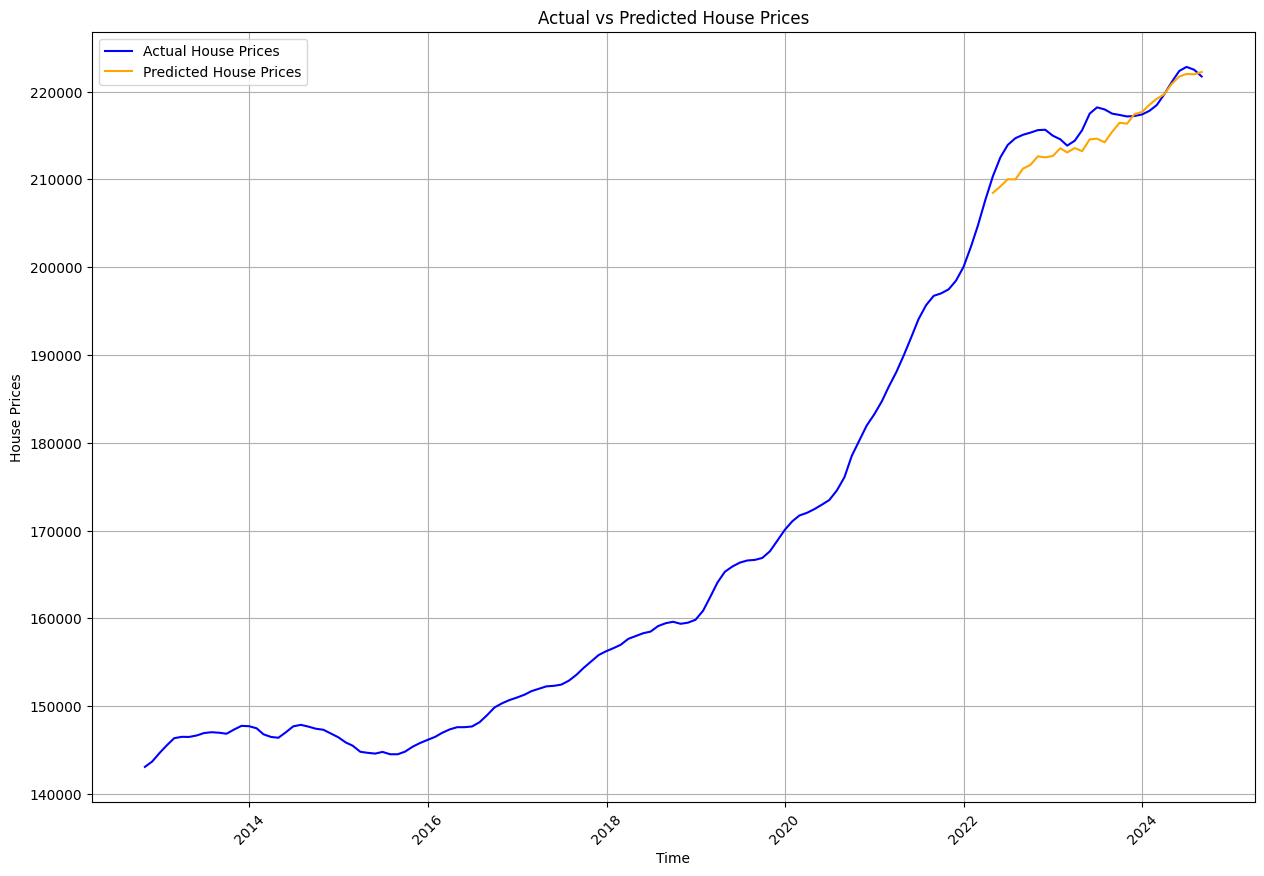

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predicted_df is your DataFrame with actual and predicted values

# Create the Seaborn plot
plt.figure(figsize=(15, 10))
sns.lineplot(data=predicted_df, x=predicted_df.index, y='Actual', label='Actual House Prices', color='blue')
sns.lineplot(data=predicted_df, x=predicted_df.index, y='Predicted', label='Predicted House Prices', color='orange')

# Set plot title and labels
plt.xlabel('Time')
plt.ylabel('House Prices')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.show()
